## Preprocessing

In [1]:
import os
import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance
import lightgbm as lgb
from lightgbm import LGBMClassifier
from sklearn.preprocessing import LabelEncoder
import shap
import matplotlib.pyplot as plt
import tqdm
from timeit import default_timer as timer

from sklearn import metrics
from sklearn.model_selection import LeaveOneOut
from sklearn.inspection import permutation_importance
from sklearn.model_selection import cross_validate

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [2]:
os.chdir('c:/users/fre_f/pythonprojects/bacteriological/')

In [3]:
df = pd.read_csv('./data/final/01_phylum_desl_ra.csv')

In [4]:
df.head()

,Index,DESL,None;Other,Archaea;Euryarchaeota,Bacteria;Acidobacteria,Bacteria;Actinobacteria,Bacteria;Armatimonadetes,Bacteria;Bacteroidetes,Bacteria;Chlamydiae,Bacteria;Chloro1lexi,...,Light treatment,OSDI score,DEQ5 score,TBUT OD,TBUT OS,OSS OD,OSS OS,Schirmer OD,Schirmer OS,Demodicosis
0,P1,3,0.000000,0.000000,0.0,0.076111,0.0,0.059049,0,0.0,...,0,NaN,NaN,3,3,0,0,23,23,0
1,P2,3,0.000000,0.000000,0.0,0.633781,0.0,0.008703,0,0.0,...,0,31.25,17.0,2,4,1,3,14,18,0
2,P3,2,0.000233,0.007146,0.0,0.083282,0.0,0.065788,0,0.0,...,1,33.30,16.0,8,8,3,3,11,8,0
3,P4,3,0.000000,0.000000,0.0,0.163522,0.0,0.013764,0,0.0,...,0,93.75,21.0,3,2,2,2,12,11,0
4,P5,1,0.000164,0.000000,0.0,0.225815,0.0,0.035394,0,0.0,...,1,6.25,7.0,11,11,0,0,22,32,0


In [5]:
df.iloc[:,2:27]

,None;Other,Archaea;Euryarchaeota,Bacteria;Acidobacteria,Bacteria;Actinobacteria,Bacteria;Armatimonadetes,Bacteria;Bacteroidetes,Bacteria;Chlamydiae,Bacteria;Chloro1lexi,Bacteria;Cyanobacteria,Bacteria;Deinococcus-Thermus,...,Bacteria;NA,Bacteria;Nitrospirae,Bacteria;Parcubacteria,Bacteria;Proteobacteria,Bacteria;Saccharibacteria,Bacteria;Spirochaetae,Bacteria;Synergistetes,Bacteria;Tenericutes,Bacteria;Thermotogae,Bacteria;Verrucomicrobia
0,0.000000,0.000000,0.0,0.076111,0.0,0.059049,0,0.0,0.010153,0.015403,...,0.0,0,0.000000,0.464638,0.0,0.0,0.0,0.000000,0.0,0.000000
1,0.000000,0.000000,0.0,0.633781,0.0,0.008703,0,0.0,0.000000,0.000000,...,0.0,0,0.000000,0.132169,0.0,0.0,0.0,0.000000,0.0,0.000000
2,0.000233,0.007146,0.0,0.083282,0.0,0.065788,0,0.0,0.000000,0.000000,...,0.0,0,0.000000,0.349757,0.0,0.0,0.0,0.000000,0.0,0.018880
3,0.000000,0.000000,0.0,0.163522,0.0,0.013764,0,0.0,0.000000,0.005638,...,0.0,0,0.000000,0.423237,0.0,0.0,0.0,0.000000,0.0,0.000000
4,0.000164,0.000000,0.0,0.225815,0.0,0.035394,0,0.0,0.000000,0.000000,...,0.0,0,0.000000,0.432492,0.0,0.0,0.0,0.000000,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56,0.000159,0.000000,0.0,0.321918,0.0,0.012240,0,0.0,0.000000,0.000000,...,0.0,0,0.016245,0.306415,0.0,0.0,0.0,0.000000,0.0,0.000000
57,0.000000,0.000000,0.0,0.113205,0.0,0.069306,0,0.0,0.085886,0.000000,...,0.0,0,0.000000,0.300344,0.0,0.0,0.0,0.000000,0.0,0.000000
58,0.000000,0.006446,0.0,0.270795,0.0,0.035212,0,0.0,0.000000,0.000000,...,0.0,0,0.000000,0.108048,0.0,0.0,0.0,0.000476,0.0,0.000000
59,0.000000,0.000000,0.0,0.728154,0.0,0.011401,0,0.0,0.001104,0.000000,...,0.0,0,0.000000,0.139687,0.0,0.0,0.0,0.000000,0.0,0.003388


In [6]:
df.iloc[:,1]

0     3
1     3
2     2
3     3
4     1
     ..
56    3
57    2
58    2
59    2
60    3
Name: DESL, Length: 61, dtype: int64

In [7]:
X = df.iloc[:,2:27]
y = df.iloc[:,1]

## Cross validate with leave one out and explain according to average of estimators

### XGBoost

In [8]:
le = LabelEncoder()
y_xgb = le.fit_transform(y)


clfxgb = XGBClassifier(random_state=42)
looxgb = LeaveOneOut()
xgb_scores = cross_validate(clfxgb, X, y_xgb, cv=looxgb, scoring='accuracy', return_estimator=True)


In [ ]:
xgb_scores

In [ ]:
feature_importances_complete = []

for idx, estimator in enumerate(xgb_scores['estimator']):
    print(f'The most important features for estimator {idx}:')
    feature_importances = pd.DataFrame(estimator.feature_importances_,
                                       index=X.columns,
                                       columns=['Importance']).sort_values('Importance', ascending=False)
    print(feature_importances)
    feature_importances_complete.append(feature_importances)

feature_importances_complete = pd.concat(feature_importances_complete)

In [11]:
feature_importances_complete

,Importance
Bacteria;1usobacteria,0.239290
Bacteria;Elusimicrobia,0.195636
Bacteria;Deinococcus-Thermus,0.129284
Bacteria;NA,0.110585
Bacteria;Verrucomicrobia,0.096714
...,...
Archaea;Euryarchaeota,0.000000
Bacteria;Chloro1lexi,0.000000
Bacteria;Chlamydiae,0.000000
Bacteria;Armatimonadetes,0.000000


In [12]:
feature_importances_complete.shape

(1525, 1)

In [13]:
fic = feature_importances_complete.groupby(level=0).mean().sort_values('Importance', ascending=False)

In [14]:
fic[:15]

,Importance
Bacteria;1usobacteria,0.212625
Bacteria;Elusimicrobia,0.152184
Bacteria;Verrucomicrobia,0.144425
Bacteria;NA,0.127928
Bacteria;Bacteroidetes,0.061675
Bacteria;Actinobacteria,0.056874
Bacteria;Proteobacteria,0.053251
None;Other,0.045908
Bacteria;1irmicutes,0.043001
Bacteria;Cyanobacteria,0.039585


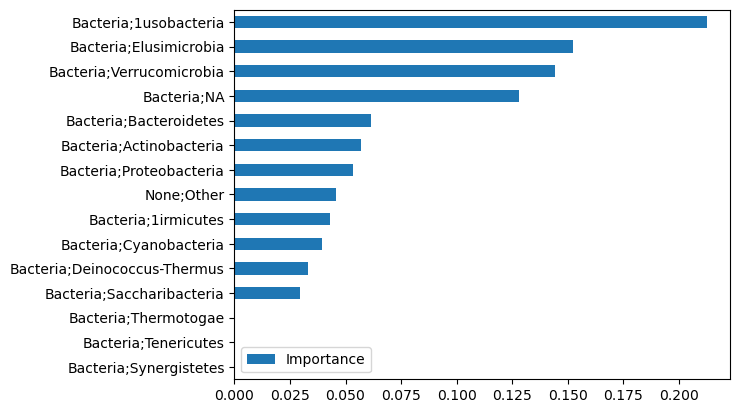

In [15]:
plot_fic = fic[:15]
plot_fic.plot(kind='barh').invert_yaxis()

In [ ]:
for estimator in xgb_scores['estimator']:
    explainerxgb = shap.Explainer(estimator, X)
    shap_valuesxgb = explainerxgb.shap_values(X)

In [17]:
np.shape(shap_valuesxgb)

(4, 61, 25)

In [18]:
shap_valuesxgb_mean = np.mean(shap_valuesxgb, axis=1)

In [19]:
np.shape(shap_valuesxgb_mean)

(4, 25)

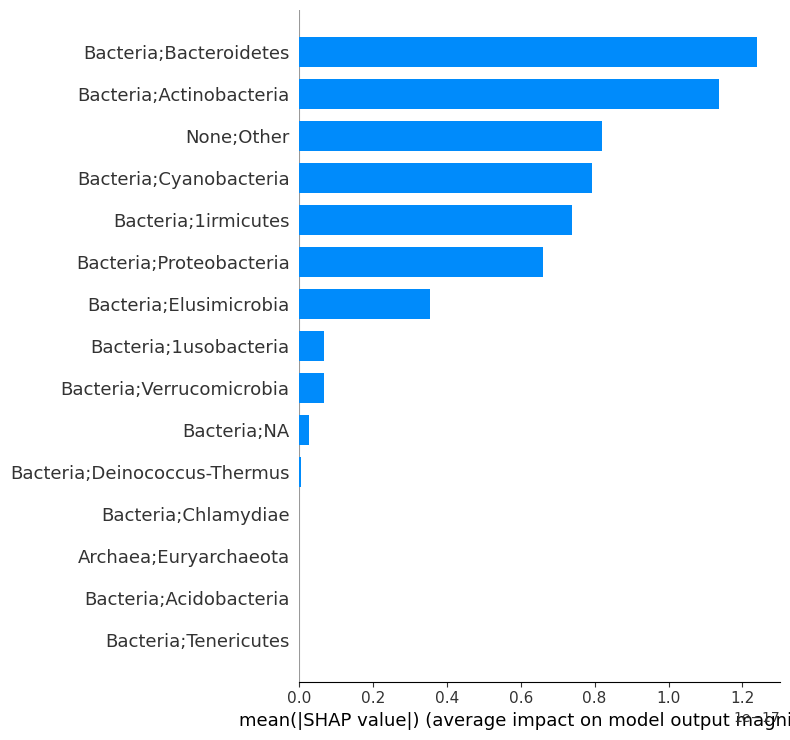

In [20]:
shap.summary_plot(shap_valuesxgb_mean, X, plot_type='bar', max_display=15)

### LightGBM

In [ ]:
clflgbm = LGBMClassifier(random_state=42)
loolgbm = LeaveOneOut()
lgbm_scores = cross_validate(clflgbm, X, y, cv=loolgbm, scoring='accuracy', return_estimator=True)

In [ ]:
lgbm_scores

In [ ]:
feature_importances_complete_lgb = []

for idx, estimator in enumerate(lgbm_scores['estimator']):
    print(f'The most important features for estimator {idx}:')
    feature_importances_lgb = pd.DataFrame(estimator.feature_importances_,
                                       index=X.columns,
                                       columns=['Importance']).sort_values('Importance', ascending=False)
    print(feature_importances_lgb)
    feature_importances_complete_lgb.append(feature_importances_lgb)

feature_importances_complete_lgb = pd.concat(feature_importances_complete_lgb)

In [24]:
feature_importances_complete_lgb

,Importance
Bacteria;Actinobacteria,130
Bacteria;Bacteroidetes,127
Bacteria;Proteobacteria,106
Bacteria;1irmicutes,75
None;Other,37
...,...
Bacteria;Chloro1lexi,0
Bacteria;Chlamydiae,0
Bacteria;Armatimonadetes,0
Bacteria;Acidobacteria,0


In [25]:
fic_lgb = feature_importances_complete_lgb.groupby(level=0).mean().sort_values('Importance', ascending=False)

In [26]:
fic_lgb[:15]

,Importance
Bacteria;Proteobacteria,126.934426
Bacteria;Bacteroidetes,119.491803
Bacteria;Actinobacteria,91.573770
Bacteria;1irmicutes,91.131148
None;Other,47.311475
Bacteria;Cyanobacteria,17.754098
Bacteria;Nitrospirae,0.000000
Bacteria;Verrucomicrobia,0.000000
Bacteria;Thermotogae,0.000000
Bacteria;Tenericutes,0.000000


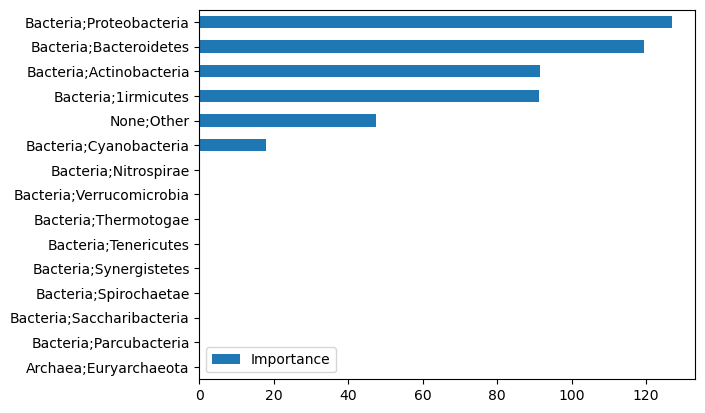

In [27]:
plot_fic_lgb = fic_lgb[:15]
plot_fic_lgb.plot(kind='barh').invert_yaxis()

In [28]:
for estimator in lgbm_scores['estimator']:
    explainerlgb = shap.Explainer(estimator, X)
    shap_valueslgb = explainerlgb.shap_values(X)    
    

In [29]:
np.shape(shap_valueslgb)

(4, 61, 25)

In [30]:
shap_valueslgb_mean = np.mean(shap_valueslgb, axis=1)

In [31]:
np.shape(shap_valueslgb_mean)

(4, 25)

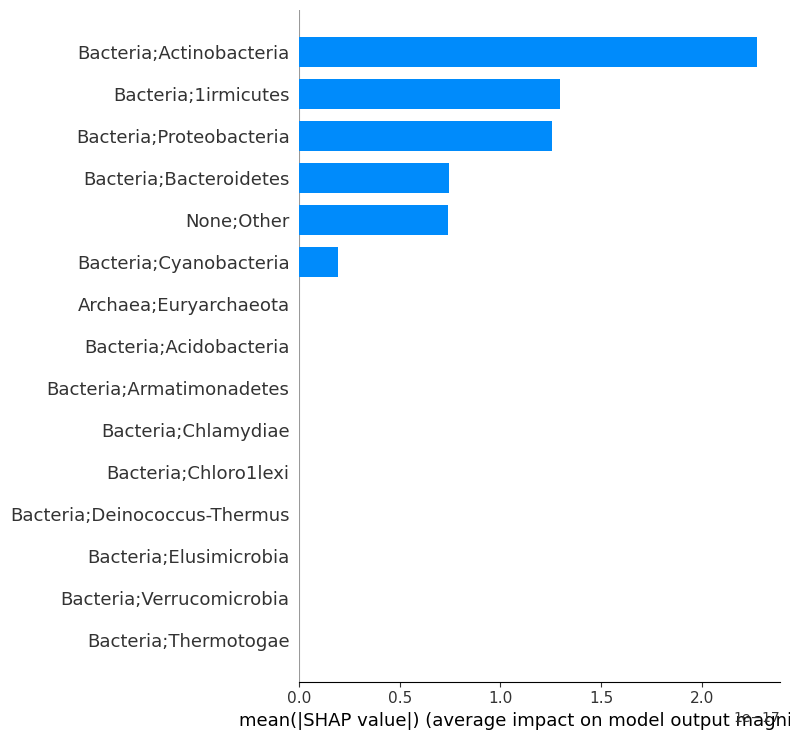

In [32]:
shap.summary_plot(shap_valueslgb_mean, X, plot_type='bar', max_display=15)

### Multilayer perceptron 

In [33]:
from sklearn.neural_network import MLPClassifier
clfmlp = MLPClassifier(solver="adam", activation="relu", learning_rate="constant", random_state=42, max_iter=30000, verbose=False)
clfmlp.out_activation_="softmax"

loomlp = LeaveOneOut()
mlp_scores = cross_validate(clfmlp, X, y, cv=loomlp, scoring='accuracy', return_estimator=True)

In [ ]:
mlp_scores

In [ ]:
# Every estimator in mlp_scores need to be fitted and permutation importance run on each estimator.
MLP_feature_importances_complete = []

for idx, estimator in enumerate(mlp_scores['estimator']):
    mlpimportance = estimator.fit(X, y)
    result = permutation_importance(mlpimportance,X, y,n_repeats=20, random_state = 42)
    MLPfeatures = pd.DataFrame(mlpimportance.feature_names_in_,columns=['Features'])
    MLPfeatures['Importance'] = result.importances_mean.tolist()
    #Sort by importance
    MLPfeatures = MLPfeatures.sort_values(by = 'Importance',ascending=False)
    print(f'The most important features for estimator {idx}:')
    print(MLPfeatures)
    MLP_feature_importances_complete.append(MLPfeatures)

MLP_feature_importances_complete = pd.concat(MLP_feature_importances_complete)

In [36]:
MLPfeatures.shape

(25, 2)

In [37]:
MLP_feature_importances_complete.shape

(1525, 2)

In [38]:
fic_mlp = MLP_feature_importances_complete.groupby('Features').mean().sort_values('Importance', ascending=False)

In [39]:
fic_mlp.shape

(25, 1)

In [40]:
fic_mlp[:15]

,Importance
Features,
Bacteria;Actinobacteria,0.410656
Bacteria;Proteobacteria,0.400820
Bacteria;1irmicutes,0.345082
Bacteria;Bacteroidetes,0.131967
Bacteria;Verrucomicrobia,0.072131
Bacteria;Elusimicrobia,0.054098
Bacteria;Cyanobacteria,0.050000
Bacteria;Deinococcus-Thermus,0.045902
Bacteria;Saccharibacteria,0.039344


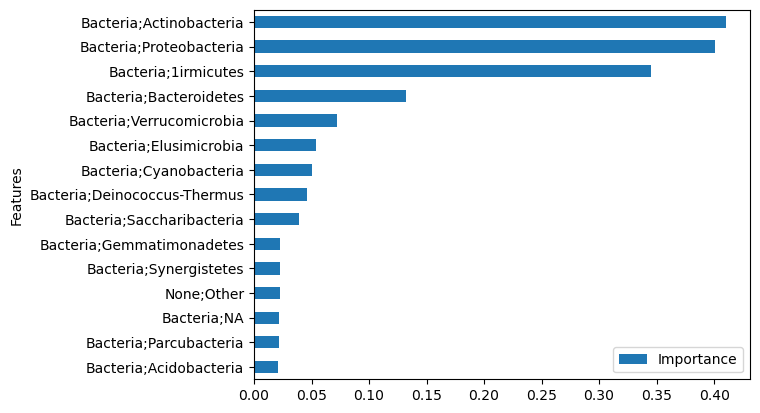

In [41]:
plot_fic_mlp = fic_mlp[:15]
plot_fic_mlp.plot(kind='barh').invert_yaxis()

In [43]:
for estimator in mlp_scores['estimator']:
    explainermlp = shap.Explainer(mlpimportance.predict, X)
    shap_valuesmlp = explainermlp.shap_values(X)

In [44]:
np.shape(shap_valuesmlp)

(61, 25)

In [45]:
shap_valuesmlp

array([[-2.29508197e-02,  1.63934426e-03,  6.55737705e-03, ...,
         0.00000000e+00, -1.47540984e-02,  2.78688525e-02],
       [-7.54098361e-02,  1.63934426e-03,  1.63934426e-03, ...,
        -1.47540984e-02, -1.80327869e-02,  3.44262295e-02],
       [-2.45901639e-02, -1.03278689e-01,  4.44089210e-17, ...,
        -3.27868852e-03, -9.83606557e-03, -4.14754098e-01],
       ...,
       [-2.29508197e-02, -6.55737705e-02,  3.27868852e-03, ...,
         8.19672131e-03, -2.29508197e-02,  2.62295082e-02],
       [-2.29508197e-02,  6.55737705e-03,  3.27868852e-03, ...,
        -1.14754098e-02, -2.13114754e-02, -3.26229508e-01],
       [ 2.63934426e-01,  0.00000000e+00,  4.91803279e-03, ...,
         0.00000000e+00, -9.83606557e-03,  3.11475410e-02]])

In [46]:
shap_valuesmlp_mean = np.mean(shap_valuesmlp, axis=0, keepdims=True)

In [47]:
np.shape(shap_valuesmlp_mean)

(1, 25)

In [ ]:
shap_valueslgb_mean

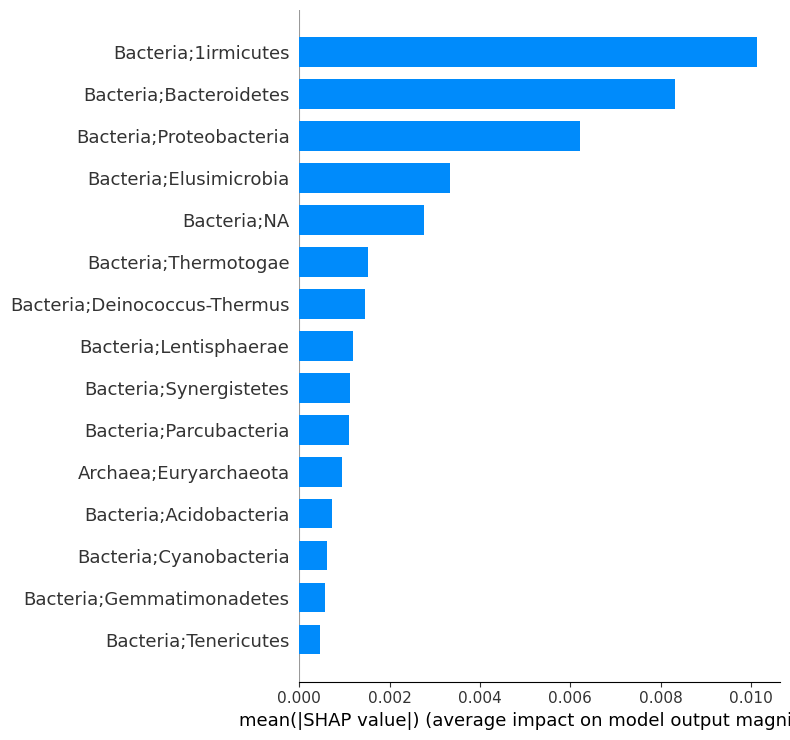

In [49]:
shap.summary_plot(shap_valuesmlp_mean, X, plot_type='bar', max_display=15)